In [7]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.svm import LinearSVR, SVR

import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [8]:
# Think of a SVM as a classifier with a decision boundary that has a wide margin
# SVMs are sensitive to feature scaling so it is important to scale the data before training
# hard margin classification: all instances must be off the margin and on the right side of the boundary
# soft margin classification: allows some instances to be on the wrong side of the margin or even on the wrong side of the boundary
# when you use a low C value, then it allows the street to be larger but more margin violations will occur
# if you SVM model is overfitting, you can try regularizing it by reducing
iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
Y = iris.target == 2

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42))
svm_clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

In [9]:
X_new = [[5.5, 1.7], [4.5, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

In [10]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.65290642])

Nonlinear svm Classification

In [11]:
# most datasets are not linearly separable so you can use polynomial features to make them linearly separable
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10000, random_state=42),
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

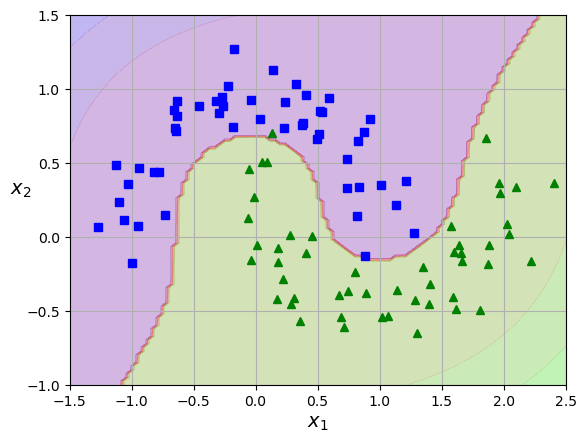

In [12]:
# extra code – this cell generates figure


def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)


def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)


plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [13]:
# polynomial kernal
poly_kernel_svm_clf = make_pipeline(
    StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5)
)
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

Gaussian RBF Kernel

In [14]:
rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(), SVC(kernel="rbf", gamma=5, C=0.001)
)
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

SVM Regression

In [15]:
# to use SVMs for regression instead of classification the trick is to tweak the objective instead of tryig to fit the largest possible street between two classes while limiting violations, SVM regression tries to fit as many possible instances on the street the width is controlled by epsilon. reducing epsilon increases the number of support vectors which regularized the model
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(), LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

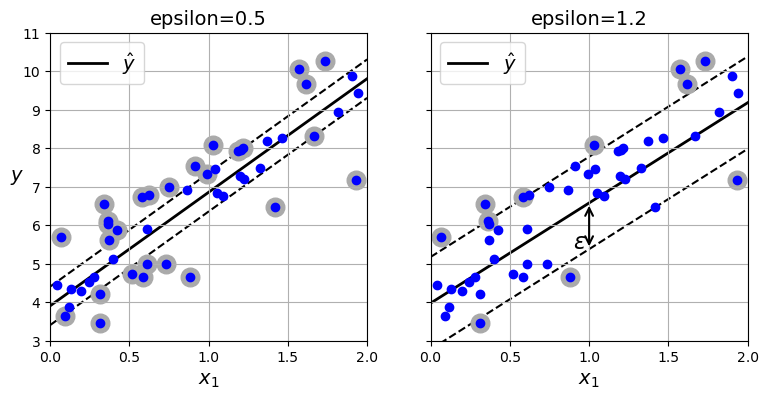

In [16]:
# extra code
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)


def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(
        X[svm_reg._support], y[svm_reg._support], s=180, facecolors="#AAA", zorder=-1
    )
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)


svm_reg2 = make_pipeline(StandardScaler(), LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
    "",
    xy=(eps_x1, eps_y_pred),
    xycoords="data",
    xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
    textcoords="data",
    arrowprops={"arrowstyle": "<->", "linewidth": 1.5},
)
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
plt.show()

In [17]:
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10
# generate a quadratic dataset
svm_poly_reg = make_pipeline(
    StandardScaler(), SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
)
# this supports the kernel= method
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])